# Gene Ontology Analysis
# Phase 2 vs. Phase 2
using output from [deseq_p2.v.p2.ipynb](https://github.com/jgmcdonough/CE24_RNA-seq/blob/main/analysis/diff_expression/phase2_v_phase2/deseq_p2.v.p2.ipynb)

following workflow described [here](https://robertslab.github.io/resources/bio-Annotation/) from the Roberts Lab

## 0. load libraries

In [2]:
# for gene ontology
library(GSEABase)
library(GO.db)

# for data formatting
library(tidyverse)

# for combining plots
library(patchwork)

# for upset plot
library(UpSetR)

## 1. Map GO IDs to gene IDs

In [3]:
# read in gene ID to GO file
gene2go <- read.csv('/work/pi_sarah_gignouxwolfsohn_uml_edu/julia_mcdonough_student_uml_edu/ref_files/annotations/geneGO.txt', sep = '\t')
head(gene2go)

,gene,Gene.Ontology.IDs
,<chr>,<chr>
1,LOC111126949,GO:0005042; GO:0005737; GO:0008233; GO:0016020; GO:0043123; GO:0046330
2,LOC111112434,GO:0000981; GO:0003700; GO:0005634; GO:0016607; GO:0043565; GO:0045944
3,LOC111120752,GO:0004750; GO:0005829; GO:0005975; GO:0006098; GO:0009052; GO:0042802; GO:0042803; GO:0046872; GO:0070062
4,LOC111105685,GO:0003682; GO:0004518; GO:0005634; GO:0035098; GO:0035102; GO:0040029; GO:0046872
5,LOC111113860,GO:0004062; GO:0005737; GO:0006068; GO:0006805; GO:0008146; GO:0009812; GO:0030855; GO:0042403; GO:0050427; GO:0051923
6,LOC111109550,GO:0004062; GO:0005737; GO:0005764; GO:0008146; GO:0051923


## 2. Create `gene2goSlim` function
to reduce code redundancy

**code is taken directly from Roberts Lab Annotation Handbook** - see [here](https://robertslab.github.io/resources/bio-Annotation/#map-go-ids-to-goslims)
- but this is slightly modified to allow the user to input which GO processes they want to get returned (BP, MF, or CC)

see bottom of code notebook for outputs of various parts of this function

In [4]:
gene2goSlim <- function(gene2go, deg_df, ontology = "BP") {

    gene_go <- left_join(deg_df, gene2go, by = "gene")

colnames(gene_go) <- c('gene_id', 'Gene.Ontology.IDs')
    
# Column names corresponding to gene name/ID and GO IDs
GO.ID.column <- "Gene.Ontology.IDs"
gene.ID.column <- "gene_id"

# Relative path or URL to input file
### BOTH vs. CONTROL
input.file <- gene_go

##### Official GO info - no need to change #####
goslims_obo <- "goslim_generic.obo"
goslims_url <- "http://current.geneontology.org/ontology/subsets/goslim_generic.obo"

# Find GSEAbase installation location
gseabase_location <- find.package("GSEABase")

# Load path to GOslim OBO file
goslim_obo_destintation <- file.path(gseabase_location, "extdata", goslims_obo, fsep = "/")

# Download the GOslim OBO file
download.file(url = goslims_url, destfile = goslim_obo_destintation)

# Loads package files
gseabase_files <- system.file("extdata", goslims_obo, package="GSEABase")

# read in gene file
#full.gene.df <- read.csv(file = input.file, header = TRUE, sep = ",")
full.gene.df <- gene_go

# Clean whitespace, filter NA/empty rows, select columns, and split GO terms using column name variables
gene.GO.df <- full.gene.df %>%
  mutate(!!GO.ID.column := str_replace_all(.data[[GO.ID.column]], "\\s*;\\s*", ";")) %>% # Clean up spaces around ";"
  filter(!is.na(.data[[gene.ID.column]]) & !is.na(.data[[GO.ID.column]]) & .data[[GO.ID.column]] != "") %>% 
  select(all_of(c(gene.ID.column, GO.ID.column)))

# flatten file
flat.gene.GO.df <- gene.GO.df %>% separate_rows(!!sym(GO.ID.column), sep = ";")

# group genes by GO.ID
grouped.gene.GO.df <- flat.gene.GO.df %>%
  group_by(!!sym(GO.ID.column)) %>%
  summarise(!!gene.ID.column := paste(.data[[gene.ID.column]], collapse = ","))

# Vector of GO IDs
go_ids <- grouped.gene.GO.df[[GO.ID.column]]

# create new OBO collection object of just GOslims, based on provided GO IDs
# Create GSEAbase GOCollection using `go_ids`
myCollection <- GOCollection(go_ids)

# Retrieve GOslims from GO OBO file set
slim <- getOBOCollection(gseabase_files)

# Retrieve Biological Process (BP) GOslims
slimdf <- goSlim(myCollection, slim, ontology, verbose = verbose)

# construct the offspring name dynamically
offspring_name <- switch(ontology,
                         BP = 'GOBPOFFSPRING',
                         MF = 'GOMFOFFSPRING',
                         CC = 'GOCCOFFSPRING')

# retrieve correct offspring object
offspring_obj <- get(offspring_name)
    
# List of GOslims and all GO IDs from `go_ids`
gomap <- as.list(offspring_obj[rownames(slimdf)])

# Maps `go_ids` to matching GOslims
mapped <- lapply(gomap, intersect, ids(myCollection))

# Append all mapped GO IDs to `slimdf`
# `sapply` needed to apply paste() to create semi-colon delimited values
slimdf$GO.IDs <- sapply(lapply(gomap, intersect, ids(myCollection)), paste, collapse=";")

# Remove "character(0) string from "GO.IDs" column
slimdf$GO.IDs[slimdf$GO.IDs == "character(0)"] <- ""

# Add self-matching GOIDs to "GO.IDs" column, if not present
for (go_id in go_ids) {
  # Check if the go_id is present in the row names
  if (go_id %in% rownames(slimdf)) {
    # Check if the go_id is not present in the GO.IDs column
    # Also removes white space "trimws()" and converts all to upper case to handle
    # any weird, "invisible" formatting issues.
    if (!go_id %in% trimws(toupper(strsplit(slimdf[go_id, "GO.IDs"], ";")[[1]]))) {
      # Append the go_id to the GO.IDs column with a semi-colon separator
      if (length(slimdf$GO.IDs) > 0 && nchar(slimdf$GO.IDs[nrow(slimdf)]) > 0) {
        slimdf[go_id, "GO.IDs"] <- paste0(slimdf[go_id, "GO.IDs"], "; ", go_id)
      } else {
        slimdf[go_id, "GO.IDs"] <- go_id
      }
    }
  }
}

# "Flatten" file so each row is single GO ID with corresponding GOslim
# rownames_to_column needed to retain row name info
slimdf_separated <- as.data.frame(slimdf %>%
  rownames_to_column('GOslim') %>%
  separate_rows(GO.IDs, sep = ";"))

# Group by unique GO ID
grouped_slimdf <- slimdf_separated %>%
  filter(!is.na(GO.IDs) & GO.IDs != "") %>%
  group_by(GO.IDs) %>%
  summarize(GOslim = paste(GOslim, collapse = ";"),
            Term = paste(Term, collapse = ";"))

slimdf.sorted <- slimdf %>% arrange(desc(Count))

slim.count.df <- slimdf.sorted %>% 
  select(Term, Count)

return(slim.count.df)

    }

## 1. Effect of single exposure after period of recovery

In [6]:
# read in DEG file

## CC vs. WC
cc.wc_deg <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/DEGs/DEG_wc_cc.csv') %>%
select(Gene)

colnames(cc.wc_deg) <- c('gene')
head(cc.wc_deg)

,gene
,<chr>
1,LOC111116296
2,LOC111105905
3,LOC111122352
4,LOC111110995
5,LOC111109459
6,LOC111135743


In [7]:
# biological processes
cc.wc_goSlim.BP <- gene2goSlim(gene2go,cc.wc_deg, "BP")
head(cc.wc_goSlim.BP, 2)

# molecular function
cc.wc_goSlim.MF <- gene2goSlim(gene2go,cc.wc_deg, "MF")
head(cc.wc_goSlim.MF, 2)

# biological processes
cc.wc_goSlim.CC <- gene2goSlim(gene2go,cc.wc_deg, "CC")
head(cc.wc_goSlim.CC, 2)

,Term,Count
,<chr>,<int>
GO:0048856,anatomical structure development,39
GO:0030154,cell differentiation,19


,Term,Count
,<chr>,<int>
GO:0003824,catalytic activity,23
GO:0016787,hydrolase activity,9


,Term,Count
,<chr>,<int>
GO:0043226,organelle,40
GO:0005886,plasma membrane,14


In [8]:
cc.wc.BP.top20 <- cc.wc_goSlim.BP %>%
  arrange(desc(Count)) %>% # order from most to least
slice_head(n = 20)         # take top 20 rows

cc.wc.MF.top20 <- cc.wc_goSlim.MF %>%
  arrange(desc(Count)) %>% # order from most to least
slice_head(n = 20)         # take top 20 rows

cc.wc.CC.top20 <- cc.wc_goSlim.CC %>%
  arrange(desc(Count)) %>% # order from most to least
slice_head(n = 20)         # take top 20 rows

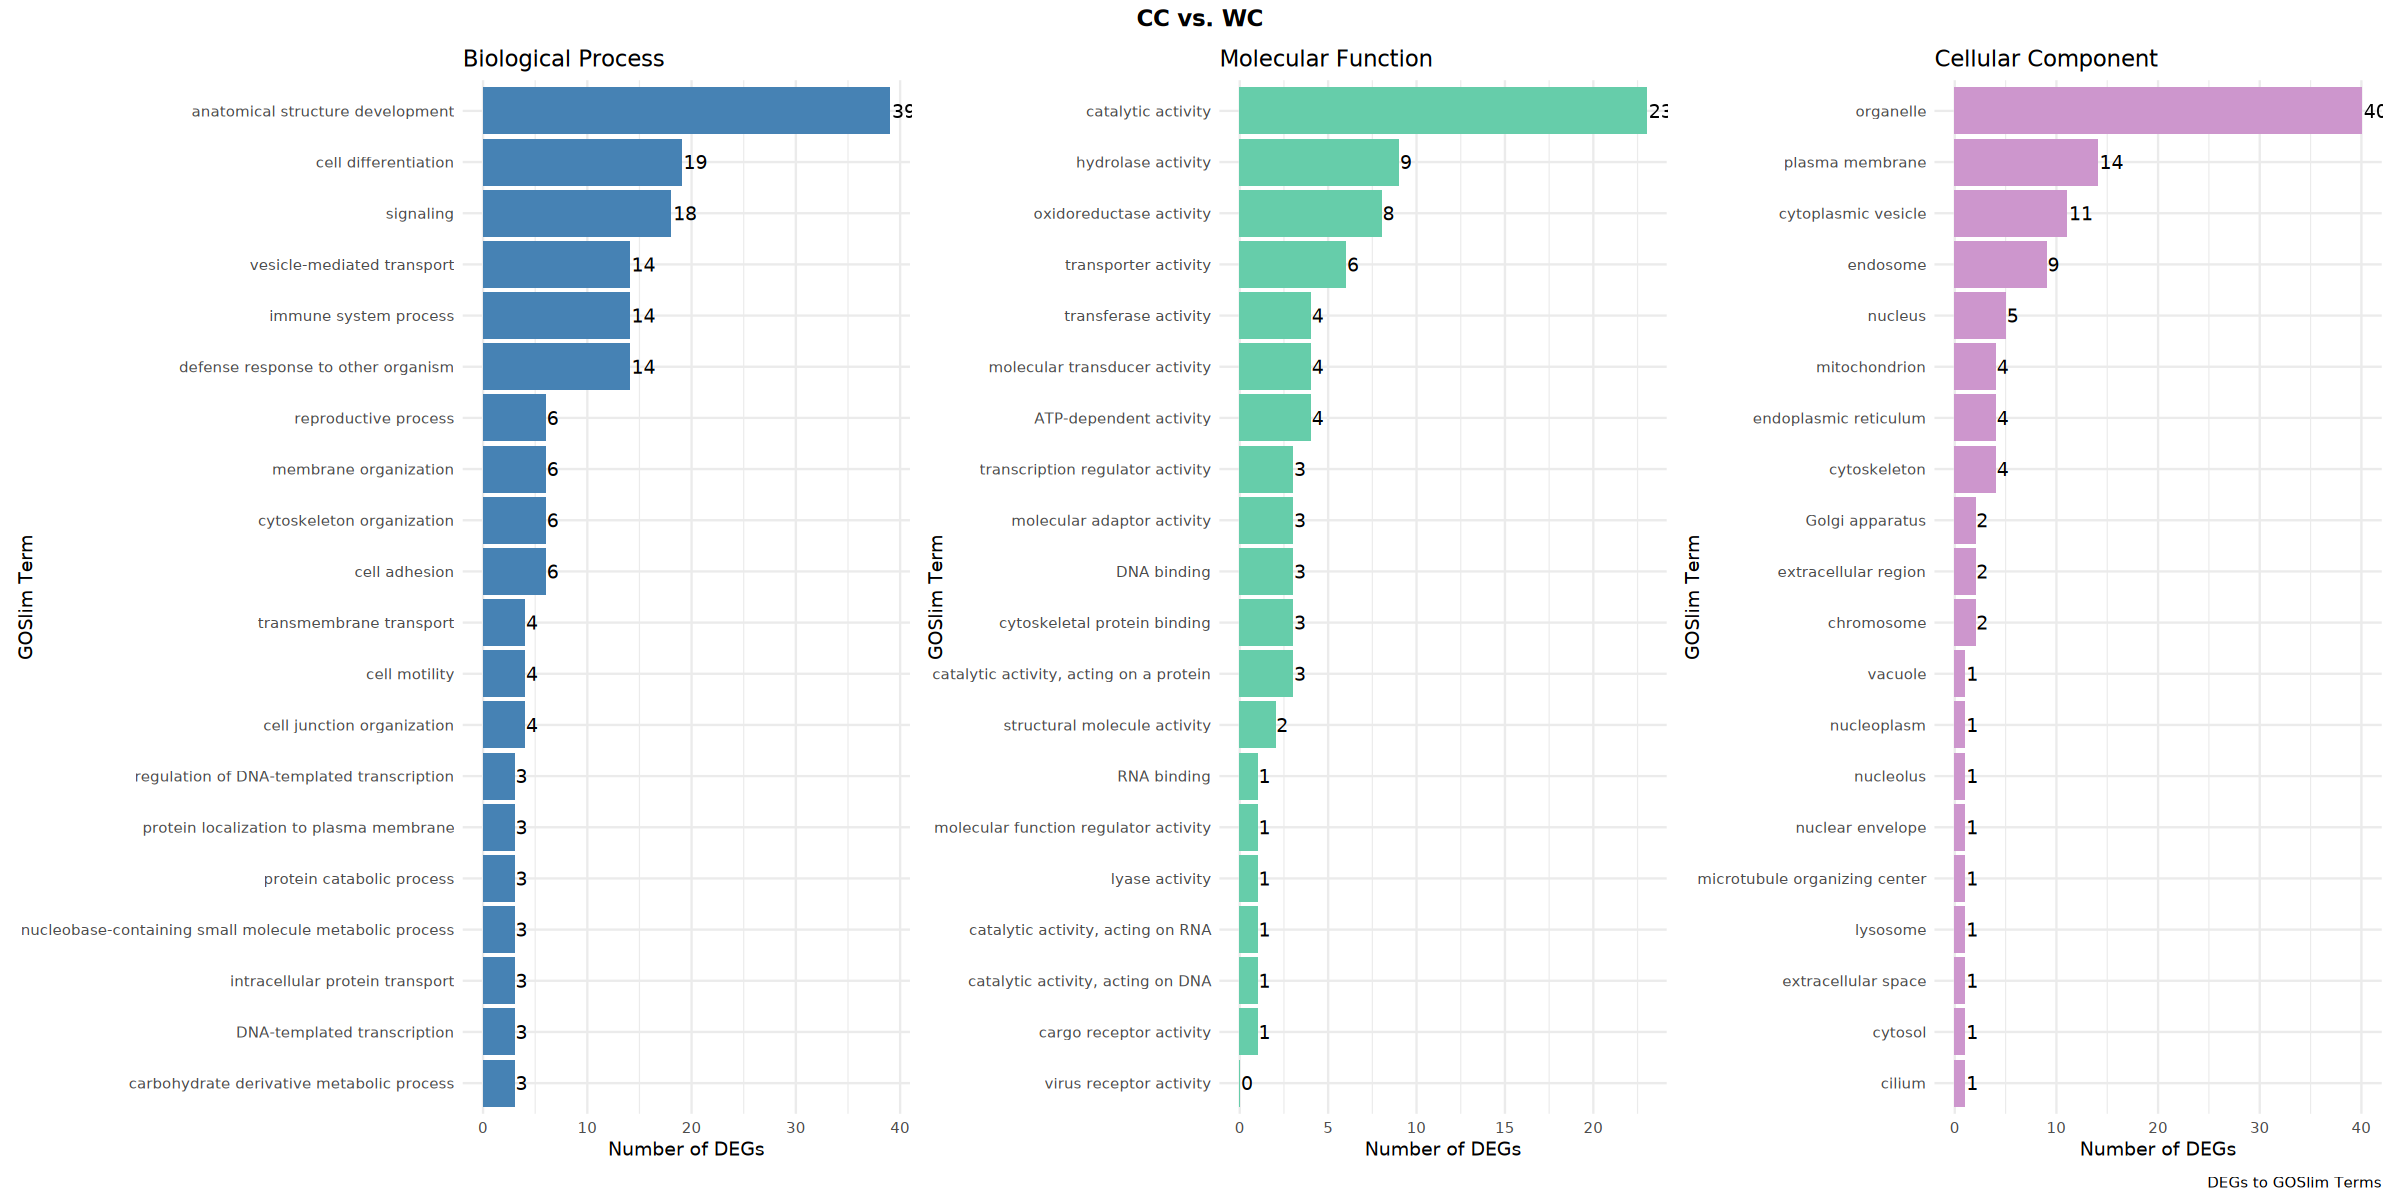

In [9]:
options(repr.plot.width=20, repr.plot.height=10)

cc.wc.bp.topPlot <- ggplot(cc.wc.BP.top20, aes(x = reorder(Term, Count), y = Count)) +
  geom_col(fill = "steelblue") +
  geom_text(aes(label = Count), hjust = -0.1) +
  coord_flip() +
  labs(
    title = "Biological Process",
    x = "GOSlim Term",
    y = "Number of DEGs"
  ) +
  theme_minimal()

cc.wc.mf.topPlot <- ggplot(cc.wc.MF.top20, aes(x = reorder(Term, Count), y = Count)) +
  geom_col(fill = "aquamarine3") +
  geom_text(aes(label = Count), hjust = -0.1) +
  coord_flip() +
  labs(
    title = "Molecular Function",
    x = "GOSlim Term",
    y = "Number of DEGs"
  ) +
  theme_minimal()

cc.wc.cc.topPlot <- ggplot(cc.wc.CC.top20, aes(x = reorder(Term, Count), y = Count)) +
  geom_col(fill = "plum3") +
  geom_text(aes(label = Count), hjust = -0.1) +
  coord_flip() +
  labs(
    title = "Cellular Component",
    x = "GOSlim Term",
    y = "Number of DEGs"
  ) +
  theme_minimal()

go.cc.wc <- cc.wc.bp.topPlot + cc.wc.mf.topPlot + cc.wc.cc.topPlot + plot_annotation('CC vs. WC',
                                                                caption = 'DEGs to GOSlim Terms',
                                                                theme=theme(plot.title=element_text(face = "bold",
                                                                                                    hjust=0.5)))

go.cc.wc

In [ ]:
ggsave('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/plots/topGO.bc_bar.pdf', go.bc, width = 20, heigh = 10)